# CNN

## Imports

Nothing to see here.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, losses, models

from src.util import load_star_galaxy_dataset, star_galaxy_split, train_val_test_split, STAR, GALAXY

%matplotlib inline

2023-04-15 16:41:34.450243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset

### Load Dataset

Here we load the whole dataset and store the target values as constants.

In [2]:
# Load dataset
dataset = load_star_galaxy_dataset()
print(f"{dataset.DESCR}\n")
print(f"Dataset size: {len(dataset.image)} images")

This is a simple dataset consisting of ~3000 64x64 images of stars and ~1000 images of galaxies. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India.

Dataset size: 3986 images


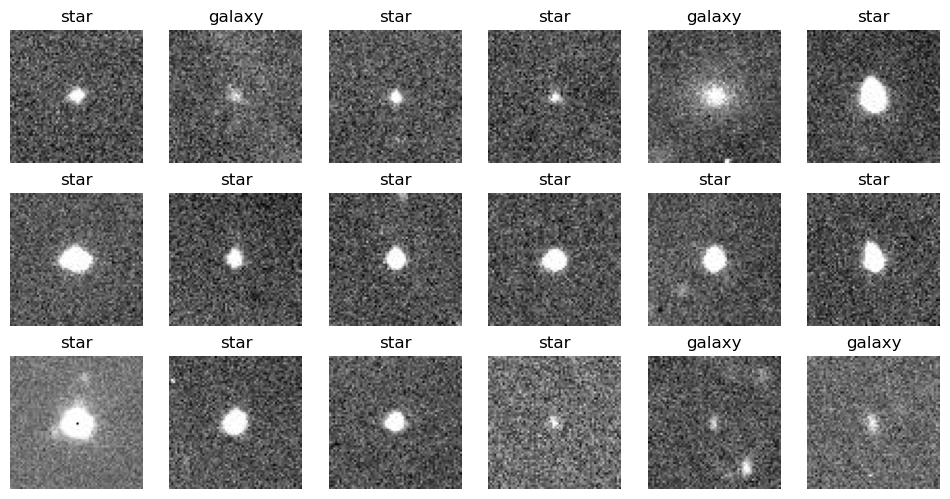

In [3]:
w, h = 6, 3

_, axs_list = plt.subplots(h, w, figsize=(2 * w, 2 * h))

_i = 0  # Index traversing the random indices
indices = np.random.choice(len(dataset.image), size=(w * h))
for axs in axs_list:
    for ax in axs:
        i = indices[_i]
        ax.axis("off")
        ax.imshow(dataset.image[i], cmap="gray")
        ax.set_title(dataset.target_names[dataset.target[i]])
        _i += 1

Now we can split the dataset into train and test sets.

In [4]:
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
    dataset.image, dataset.target
)
print(f"x_train: {x_train.shape[0]} images")
print(f"x_val: {x_val.shape[0]} images")
print(f"x_test: {x_test.shape[0]} images")

x_train: 3188 images
x_val: 399 images
x_test: 399 images


## Building the Layers

Much like an onion or an ogre, a CNN model consists of layers.

In [5]:
model = models.Sequential()
model.add(
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(64, 64, 1))
)
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))

2023-04-15 16:41:42.239209: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation="relu"))
model.add(layers.Dense(units=2))  # Output layer

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

## Training the Model

In [9]:
model.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [10]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_val, y_val),
)

Epoch 1/10
100/100 [==============================] - 19s 181ms/step - loss: 0.5216 - accuracy: 0.7694 - val_loss: 0.4715 - val_accuracy: 0.7444
Epoch 2/10
100/100 [==============================] - 17s 172ms/step - loss: 0.4226 - accuracy: 0.7933 - val_loss: 0.4929 - val_accuracy: 0.7393
Epoch 3/10
100/100 [==============================] - 18s 176ms/step - loss: 0.3648 - accuracy: 0.8287 - val_loss: 0.4280 - val_accuracy: 0.7845
Epoch 4/10
100/100 [==============================] - 17s 168ms/step - loss: 0.3049 - accuracy: 0.8623 - val_loss: 0.3684 - val_accuracy: 0.8622
Epoch 5/10
100/100 [==============================] - 17s 167ms/step - loss: 0.3056 - accuracy: 0.8673 - val_loss: 0.3923 - val_accuracy: 0.8371
Epoch 6/10
100/100 [==============================] - 18s 177ms/step - loss: 0.2670 - accuracy: 0.8830 - val_loss: 0.4384 - val_accuracy: 0.8045
Epoch 7/10
100/100 [==============================] - 21s 206ms/step - loss: 0.2363 - accuracy: 0.8999 - val_loss: 0.3660 - val_ac

## Evaluating the Model

In [11]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

100/100 - 3s - loss: 0.1232 - accuracy: 0.9617 - 3s/epoch - 31ms/step
13/13 - 0s - loss: 0.3815 - accuracy: 0.8571 - 388ms/epoch - 30ms/step
13/13 - 0s - loss: 0.3295 - accuracy: 0.8822 - 389ms/epoch - 30ms/step


Let's see how the model performed with each epoch.

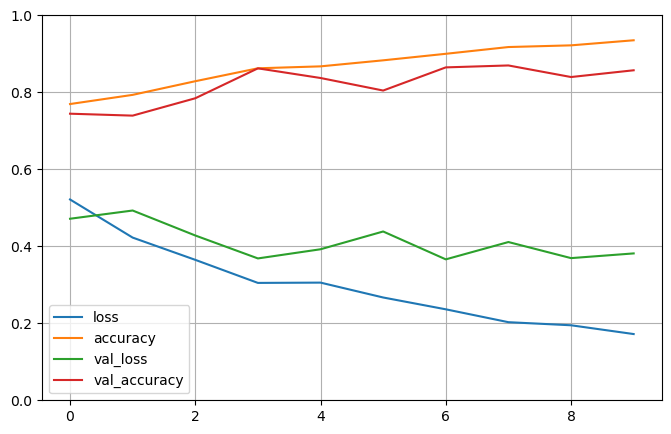

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Now, let's see how accurate it is with each dataset and (more importantly) with stars XOR galaxies. We first need to extract the subset of just the stars and also the subset of just the galaxies.

In [ ]:
for _x, _y, _name in zip([dataset.image, x_train, x_val, x_test], [dataset.target, y_train, y_val, y_test], ["full", "train", "val", "test"]):
    print(_name)
    print("-" * len(_name))
    print("overall", end="\t")
    stars, galaxies = star_galaxy_split(_x, _y)
    print("stars", end="\t")
    star_loss, star_acc = model.evaluate(stars, np.full(len(stars), STAR), verbose=2)
    print("galaxies", end="\t")
    galaxy_loss, galaxy_acc = model.evaluate(galaxies, np.full(len(galaxies), GALAXY), verbose=2)
    print()

full
----
overall	125/125 - 3s - loss: 0.1697 - accuracy: 0.9433 - 3s/epoch - 26ms/step


## Problem

The dataset we use has far more images of stars than galaxies, almost 3 times as many. This presents a challenge when it comes to classification, as the model could easily guess "star" for any given image and have essentially a 1/4 chance of being right.

## Attempt at a Solution

Our attempt at solving this problem is to only use a subset of the entire dataset. We use a sample of about 1,000 random images of the stars, to have an even number of both classes in training and testing.

In [ ]:
dataset_even = load_star_galaxy_dataset(even=True)
print(f"Even dataset size: {len(dataset_even)}")

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
    dataset_even.image, dataset_even.target
)
print(f"x_train: {x_train.shape[0]} images")
print(f"x_val: {x_val.shape[0]} images")
print(f"x_test: {x_test.shape[0]} images")

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_val, y_val),
)

In [ ]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
for _x, _y, _name in zip([dataset_even.image, x_train, x_val, x_test], [dataset_even.target, y_train, y_val, y_test], ["full", "train", "val", "test"]):
    print(_name)
    print("-" * len(_name))
    stars, galaxies = star_galaxy_split(_x, _y)
    loss, acc = model.evaluate(_x, _y, verbose=2)
    star_loss, star_acc = model.evaluate(stars, np.full(len(stars), STAR), verbose=2)
    galaxy_loss, galaxy_acc = model.evaluate(galaxies, np.full(len(galaxies), GALAXY), verbose=2)
    print()

## Conclusions

TBD